In [395]:
import numpy as np
import matplotlib.pyplot as plt
import copy

plt.style.use("seaborn")

# Homework 18 - Random numbers and processes

# Excercise 1
Calculate the probability of rolling two 6's by rolling the two fair dice 1,000,000 times. 
Compare your result to the true probability.

In [396]:
rng = np.random.default_rng()
N = 1_000_000

def two_dice(N: int = 1) -> np.ndarray:
    return np.array([
        rng.integers(low=1, high=7, size=2)
        for _ in range(N)
    ])
dice_rolls = two_dice(N)

double_six = dice_rolls[np.sum(dice_rolls, axis=1) == 12]
num = double_six.shape[0]
print(
    f"""
    The probability of rolling a double six in {N} rolls is {100*num/N:1.2f}%,
    compared to the expected probability {100 * 1/36 = :1.2f}%
    """
)



    The probability of rolling a double six in 1000000 rolls is 2.77%,
    compared to the expected probability 100 * 1/36 = 2.78%
    


# Excercise 2

Consider the radioactive decay chain of Bismuth-213 to semi-stable Bismuth-209, through the intermediate steps of Thallium anbd Lead.
<img width=200 src="decaychain.png"/>
Bi-213 has been used to <a href="https://en.wikipedia.org/wiki/Isotopes_of_bismuth">treat leukemia.</a>

- Write a simulation of this decay chain, starting with 10,000 atoms of Bi-213 and no other atoms, and take 1 second steps for 20,000 seconds. Keep track of the number of each isotope at each time step.

You have to test the chance of decay in the chain from the bottom up - starting with the decay of Pb-209 to Bi-209, then Tl-209 to Pb-209, and last Bi-213 to its two daughters. If you don't start at the bottom, and instead start at the top, you might decay the same atom twice in the same step. You will also have to add bias to the selection of which decay Bi-213 atoms undertake with the *branching ratio* probability shown.

- Make a plot of the number of atoms of each isotope over time.

In [397]:
from numba import jit
import random as randomRNG

In [398]:
t0 = 0
t1 = 20000
dt = 1

t = np.arange(t0, t1, dt)

tau_Pb209 = 3.3 * 60
tau_Tl209 = 2.2 * 60
tau_Bi213 = 46 * 60

@jit(nopython=True)
def p(tau):
    return 1 - 2**(-dt/tau)

@jit(forceobj=True)
def decay():
    num_atoms_initial = np.array([10_000, 0, 0, 0])

    num_atoms = [num_atoms_initial]
    for i in range(t.shape[0] - 1):
        atoms = copy.deepcopy(num_atoms[i])
        for j, num_atom in enumerate(atoms[::-1]):
            if j == 1:
                for _ in range(num_atom):
                    if randomRNG.uniform(0, 1) < p(tau_Pb209):
                        atoms[2] -= 1
                        atoms[3] += 1
            if j == 2:
                for _ in range(num_atom):
                    if randomRNG.uniform(0, 1) < p(tau_Tl209):
                        atoms[1] -= 1
                        atoms[2] += 1
            if j == 3:
                for _ in range(num_atom):
                    if randomRNG.uniform(0, 1) < p(tau_Bi213):
                        atoms[0] -= 1
                        if randomRNG.uniform(0, 1) > 0.0209:
                            atoms[1] += 1
                        else: 
                            atoms[2] += 1           
        num_atoms.append(atoms)
    return np.array(num_atoms)

In [399]:
num_atoms = decay()

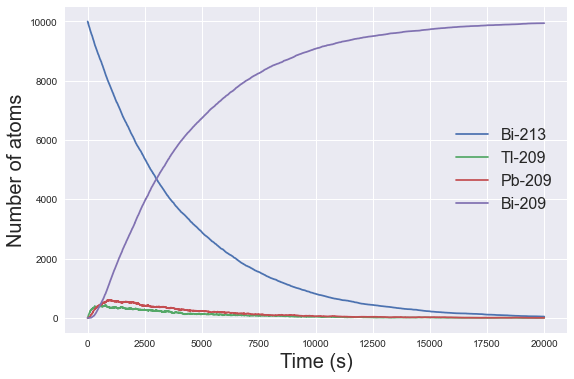

In [400]:
Bi213 = num_atoms[:, 0]
Tl209 = num_atoms[:, 1]
Pb209 = num_atoms[:, 2]
Bi209 = num_atoms[:, 3]

plt.figure(figsize=(9,6))
plt.plot(t, Bi213, label="Bi-213")
plt.plot(t, Tl209, label="Tl-209")
plt.plot(t, Pb209, label="Pb-209")
plt.plot(t, Bi209, label="Bi-209")
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Number of atoms", fontsize=20)
plt.legend(fontsize=16)
plt.show()
plt.close()

# Excercise 3

Combine the ideas from Examples 3 and 4 of the lecture notebook and generate random lifetimes for 1,000 atoms of Tl-208 by creating 1,000 random numbers from the PDF
$$p(t)dt =  \mu e^{-\mu t}$$

Instead of a histogram of these 1,000 randomly generated numbers, simply sort the array of lifetimes from smallest to longest using `numpy.sort`. For the shortest lifetime, there are $N-1$ atoms with longer lifetimes; for the next shorest lifetime, there are $N-2$ atoms with longer lifetimes, etc.

If you plot an array of integers $N\rightarrow0$ versus the generated lifetimes, you should reproduce the results from Example 3.

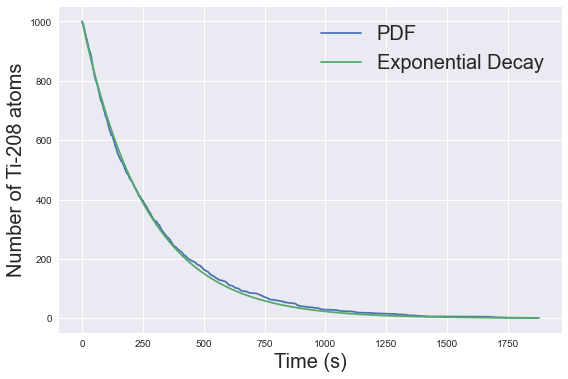

In [401]:
N = 1000

rng = np.random.default_rng()
tau = 3.053*60
mu = np.log(2)/tau

pdf = np.sort(
    rng.exponential(1/mu, N)
)

n = np.arange(N, 0, -1)
t = np.linspace(0, pdf.max(), 100)

exponential = N * np.exp(-mu*t)

plt.figure(figsize=(9,6))
plt.plot(pdf, n, label="PDF")
plt.plot(t, exponential, label="Exponential Decay")
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Number of Ti-208 atoms",fontsize=20)
plt.legend(fontsize=20)
plt.show()
plt.close()

# Excercise 4
Use the "shooting" method to estimate the area of a circle of radius 1.
<img width=200 src="circle.png"/>
A "hit" in the circle area is when randomly chosen point $(x,y)$
$$f(x,y)=\left\{\begin{array}{l}
&1&\textrm{ if }x^2+y^2\leq1\\
&0&\textrm{ otherwise}\end{array}\right.$$

Also calculate the error of the integral.

Extend your program to calculate the volume of a 10-dimensional hypershpere of radius 1 in each dimention.
A "hit" in the hypersphere is when randomly chosen point array $\{x_i\}$
$$f(\{x_i\})=\left\{\begin{array}{l}
&1&\textrm{ if }\sum x_i^2 \leq1\\
&0&\textrm{ otherwise}\end{array}\right.$$
Compare your result to the true volume of an <a href="https://en.wikipedia.org/wiki/Volume_of_an_n-ball">10-d sphere</a>, which is $\pi^5/5!$

In [402]:
def area_sphere(D: int = 2, R: float = 1, N: int = 1000):
    rng = np.random.default_rng()

    points = np.array(
        [
            rng.uniform(low=-R, high=R, size=D)
            for _ in range(N)
        ]
    )

    inside = points[
        np.sum(points**2, axis=1) <= R**2
    ]

    outside = points[
        np.sum(points**2, axis=1) > R**2
    ]

    theta = np.linspace(0, 2*np.pi, 1000)

    if D == 2:
        plt.figure(figsize=(9,9))
        plt.scatter(inside[:,0], inside[:,1], s=2)
        plt.scatter(outside[:,0], outside[:,1], s=2)
        plt.plot(R*np.cos(theta), R*np.sin(theta))
        plt.xlabel("x",fontsize=20)
        plt.ylabel("y",fontsize=20)
        plt.show()
        plt.close()

    area = inside.shape[0] * (2*R)**D / N
    error = np.sqrt(area * ((2*R)**D - area) / N)
    print(f"Volume of {D}-dimensional sphere of radius {R} is approximately {area:1.4f} +- {error:1.4f}")

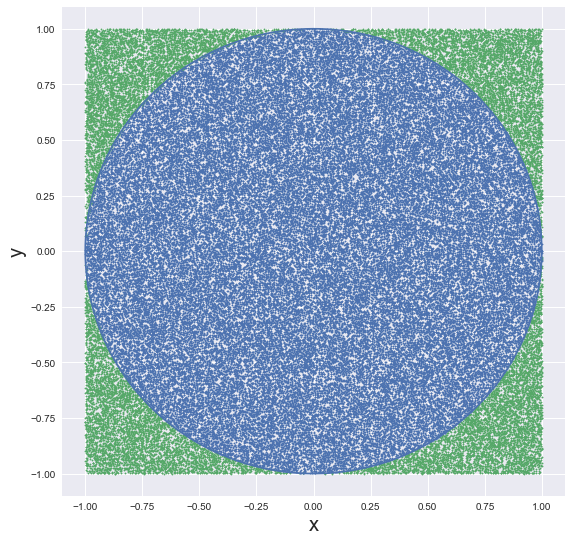

Volume of 2-dimensional sphere of radius 1 is approximately 3.1496 +- 0.0052
Actual value: A = 3.141592653589793
Volume of 10-dimensional sphere of radius 1 is approximately 2.6163 +- 0.0517
Actual value: A = 2.550164039877345


In [403]:
area_sphere(D=2, R=1, N=100_000)
print(f"Actual value: A = {np.pi}")
area_sphere(D=10, R=1, N=1_000_000)
print(f"Actual value: A = {np.pi**5/(5*4*3*2)}")

# Excercise 5
Verify the solution of the definite integral with Monte Carlo integration and importance sampling.
$$I = \int_0^1 \frac{x}{\sqrt{1-x^2}}dx=1$$

*Hint:* If we let 
$$w(x)=x,$$
then we have
$$\frac{f(x)}{w(x)}=\frac{1}{\sqrt{1-x^2}}$$
To generate values of $x$ according to the weighted function $w(x)$, we see that the PDF is
$$p(x)=\frac{x}{\int_0^1 x} dx = 2x$$
The RNG function is then
$$z=\int_0^x p(x')dx' = 2\int_0^x x dx = x^{2}$$
So we should generate random numbers by $x=\sqrt{z}$.
Then the integral is formed from the products of 
$$\left\langle \frac{f(x)}{w(x)}\right\rangle = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{\sqrt{1-x^2}}$$
and 
$$\int_0^1 w(x)dx = \int_0^1 x dx = \frac{1}{2}$$

In [404]:
def fw(x):
    return 1 / np.sqrt(1 - x**2)


rng = np.random.default_rng()

N = 100_000
sumfw = 0
sumfwsq = 0

for i in range(N):
    x = np.sqrt(rng.random())
    y = fw(x)
    sumfw += y
    sumfwsq += y*y

avgfw = sumfw / N
I = avgfw / 2
varfw = sumfwsq / N - avgfw**2
stdev = 2 * np.sqrt(varfw) / np.sqrt(N)

print(f"The integral is : {I:6.5f} +/- {stdev:6.5f}")

if 1 - stdev < I < 1 + stdev:
    print("The integral is within the error bounds")
else:
    print("The integral is outside the error bounds")

The integral is : 0.99442 +/- 0.01726
The integral is within the error bounds
